In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import random

# Configuration
DATASET_DIR = "Rust_Dataset"
IMG_HEIGHT, IMG_WIDTH = 224, 224
NUM_CLASSES = 4
NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

CLASS_NAMES = ['Heavy Visible Rust', 'No Rust', 'Slightly Visible Rust', 'Visible Rust']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Data transforms for testing
test_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(NORM_MEAN, NORM_STD)
])

# Load test dataset
test_dataset = datasets.ImageFolder(os.path.join(DATASET_DIR, 'test'), test_transform)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

print(f"Test samples: {len(test_dataset)}")
print(f"Classes: {test_dataset.classes}")

Test samples: 63
Classes: ['Heavy Visible Rust', 'No Rust', 'Slightly Visible Rust', 'Visible Rust']


In [3]:
# Load ResNet50 Model
resnet_model = models.resnet50(weights=None)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Linear(num_ftrs, NUM_CLASSES)
resnet_model.load_state_dict(torch.load('rust_resnet50.pth', map_location=device))
resnet_model = resnet_model.to(device)
resnet_model.eval()
print("✓ ResNet50 model loaded")

✓ ResNet50 model loaded


In [4]:
# Load MobileNetV2 Model
mobilenet_model = models.mobilenet_v2(weights=None)
num_ftrs = mobilenet_model.classifier[1].in_features
mobilenet_model.classifier[1] = nn.Linear(num_ftrs, NUM_CLASSES)
mobilenet_model.load_state_dict(torch.load('rust_mobilenetv2.pth', map_location=device))
mobilenet_model = mobilenet_model.to(device)
mobilenet_model.eval()
print("✓ MobileNetV2 model loaded")

✓ MobileNetV2 model loaded


In [5]:
# Load EfficientNetB0 Model
efficientnet_model = models.efficientnet_b0(weights=None)
num_ftrs = efficientnet_model.classifier[1].in_features
efficientnet_model.classifier[1] = nn.Linear(num_ftrs, NUM_CLASSES)
efficientnet_model.load_state_dict(torch.load('rust_efficientnetb0.pth', map_location=device))
efficientnet_model = efficientnet_model.to(device)
efficientnet_model.eval()
print("✓ EfficientNetB0 model loaded")

✓ EfficientNetB0 model loaded


In [ ]:
# Load DenseNet121 Model
densenet_model = models.densenet121(weights=None)
num_ftrs = densenet_model.classifier.in_features
densenet_model.classifier = nn.Linear(num_ftrs, NUM_CLASSES)
densenet_model.load_state_dict(torch.load('rust_densenet121.pth', map_location=device))
densenet_model = densenet_model.to(device)
densenet_model.eval()
print("✓ DenseNet121 model loaded")

In [ ]:
# Evaluate all models on test set
def evaluate_model(model, dataloader, model_name):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
    
    accuracy = 100 * correct / total
    print(f"{model_name} - Accuracy: {accuracy:.2f}% ({correct}/{total})")
    
    return accuracy, all_preds, all_labels, all_probs

# Evaluate all models
print("\nEvaluating models on test set...\n")
resnet_acc, resnet_preds, resnet_labels, resnet_probs = evaluate_model(resnet_model, test_loader, "ResNet50")
mobilenet_acc, mobilenet_preds, mobilenet_labels, mobilenet_probs = evaluate_model(mobilenet_model, test_loader, "MobileNetV2")
efficientnet_acc, efficientnet_preds, efficientnet_labels, efficientnet_probs = evaluate_model(efficientnet_model, test_loader, "EfficientNetB0")
densenet_acc, densenet_preds, densenet_labels, densenet_probs = evaluate_model(densenet_model, test_loader, "DenseNet121")


Evaluating models on test set...

ResNet50 - Accuracy: 79.37% (50/63)
ResNet50 - Accuracy: 79.37% (50/63)
MobileNetV2 - Accuracy: 69.84% (44/63)
MobileNetV2 - Accuracy: 69.84% (44/63)
EfficientNetB0 - Accuracy: 71.43% (45/63)
EfficientNetB0 - Accuracy: 71.43% (45/63)


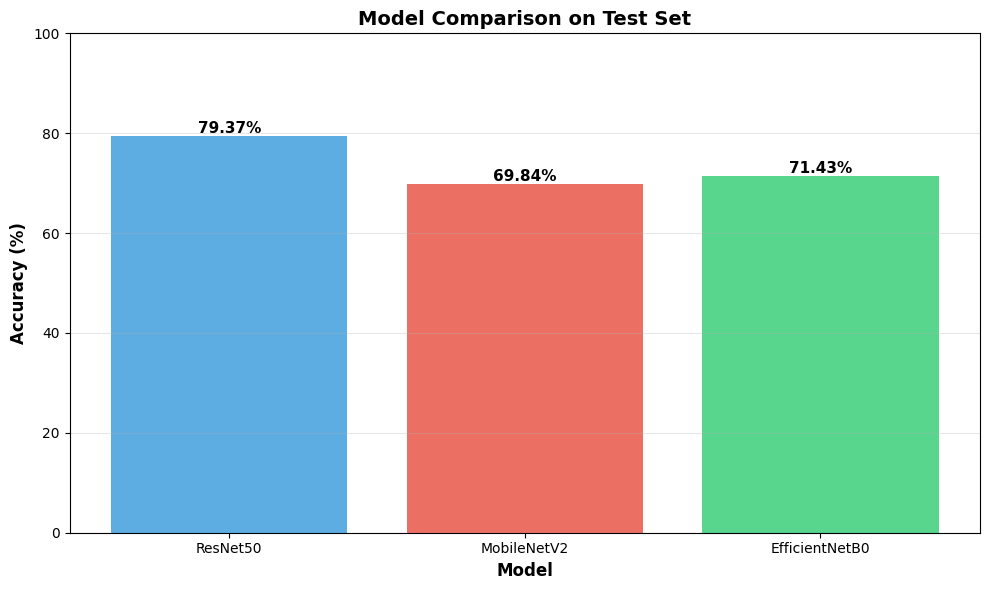

In [ ]:
# Plot accuracy comparison
models_list = ['ResNet50', 'MobileNetV2', 'EfficientNetB0', 'DenseNet121']
accuracies = [resnet_acc, mobilenet_acc, efficientnet_acc, densenet_acc]

plt.figure(figsize=(12, 6))
bars = plt.bar(models_list, accuracies, color=['#3498db', '#e74c3c', '#2ecc71', '#9b59b6'], alpha=0.8)
plt.xlabel('Model', fontsize=12, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12, fontweight='bold')
plt.title('Model Comparison on Test Set', fontsize=14, fontweight='bold')
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}%',
             ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

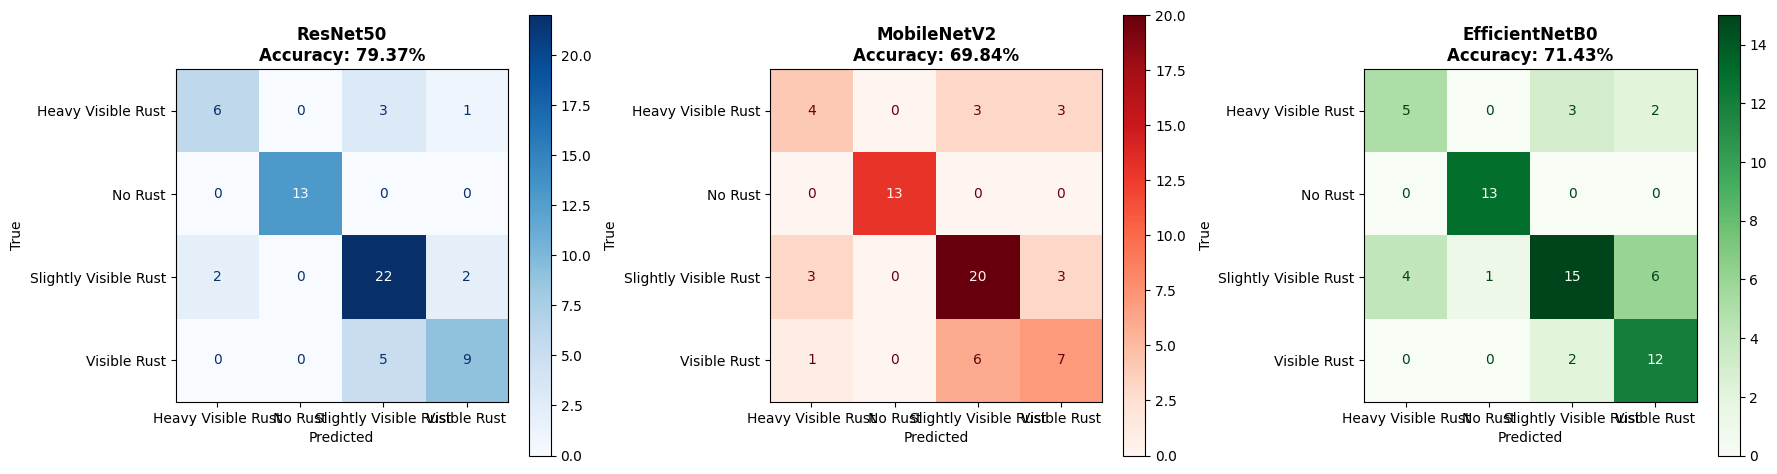

In [ ]:
# Confusion Matrix for each model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, axes = plt.subplots(2, 2, figsize=(16, 14))
axes = axes.ravel()

# ResNet50
cm_resnet = confusion_matrix(resnet_labels, resnet_preds)
disp_resnet = ConfusionMatrixDisplay(confusion_matrix=cm_resnet, display_labels=CLASS_NAMES)
disp_resnet.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title(f'ResNet50\nAccuracy: {resnet_acc:.2f}%', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Predicted', fontsize=10)
axes[0].set_ylabel('True', fontsize=10)

# MobileNetV2
cm_mobilenet = confusion_matrix(mobilenet_labels, mobilenet_preds)
disp_mobilenet = ConfusionMatrixDisplay(confusion_matrix=cm_mobilenet, display_labels=CLASS_NAMES)
disp_mobilenet.plot(ax=axes[1], cmap='Reds', values_format='d')
axes[1].set_title(f'MobileNetV2\nAccuracy: {mobilenet_acc:.2f}%', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Predicted', fontsize=10)
axes[1].set_ylabel('True', fontsize=10)

# EfficientNetB0
cm_efficientnet = confusion_matrix(efficientnet_labels, efficientnet_preds)
disp_efficientnet = ConfusionMatrixDisplay(confusion_matrix=cm_efficientnet, display_labels=CLASS_NAMES)
disp_efficientnet.plot(ax=axes[2], cmap='Greens', values_format='d')
axes[2].set_title(f'EfficientNetB0\nAccuracy: {efficientnet_acc:.2f}%', fontsize=12, fontweight='bold')
axes[2].set_xlabel('Predicted', fontsize=10)
axes[2].set_ylabel('True', fontsize=10)

# DenseNet121
cm_densenet = confusion_matrix(densenet_labels, densenet_preds)
disp_densenet = ConfusionMatrixDisplay(confusion_matrix=cm_densenet, display_labels=CLASS_NAMES)
disp_densenet.plot(ax=axes[3], cmap='Purples', values_format='d')
axes[3].set_title(f'DenseNet121\nAccuracy: {densenet_acc:.2f}%', fontsize=12, fontweight='bold')
axes[3].set_xlabel('Predicted', fontsize=10)
axes[3].set_ylabel('True', fontsize=10)

plt.tight_layout()
plt.show()

In [9]:
# Display sample predictions from each class
def denormalize(tensor):
    """Denormalize image tensor for display"""
    mean = torch.tensor(NORM_MEAN).view(3, 1, 1)
    std = torch.tensor(NORM_STD).view(3, 1, 1)
    return tensor * std + mean

def predict_and_display(model, image_tensor, true_label, model_name):
    """Make prediction and return prediction info"""
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)
        output = model(image_tensor)
        probs = torch.softmax(output, dim=1)
        confidence, predicted = torch.max(probs, 1)
    
    return predicted.item(), confidence.item()

# Get random samples from each class
samples_per_class = 3
class_samples = {i: [] for i in range(NUM_CLASSES)}

for idx, (img, label) in enumerate(test_dataset):
    if len(class_samples[label]) < samples_per_class:
        class_samples[label].append((idx, img, label))
    if all(len(samples) >= samples_per_class for samples in class_samples.values()):
        break

print("Sample images selected for visualization")

Sample images selected for visualization



Class: Heavy Visible Rust


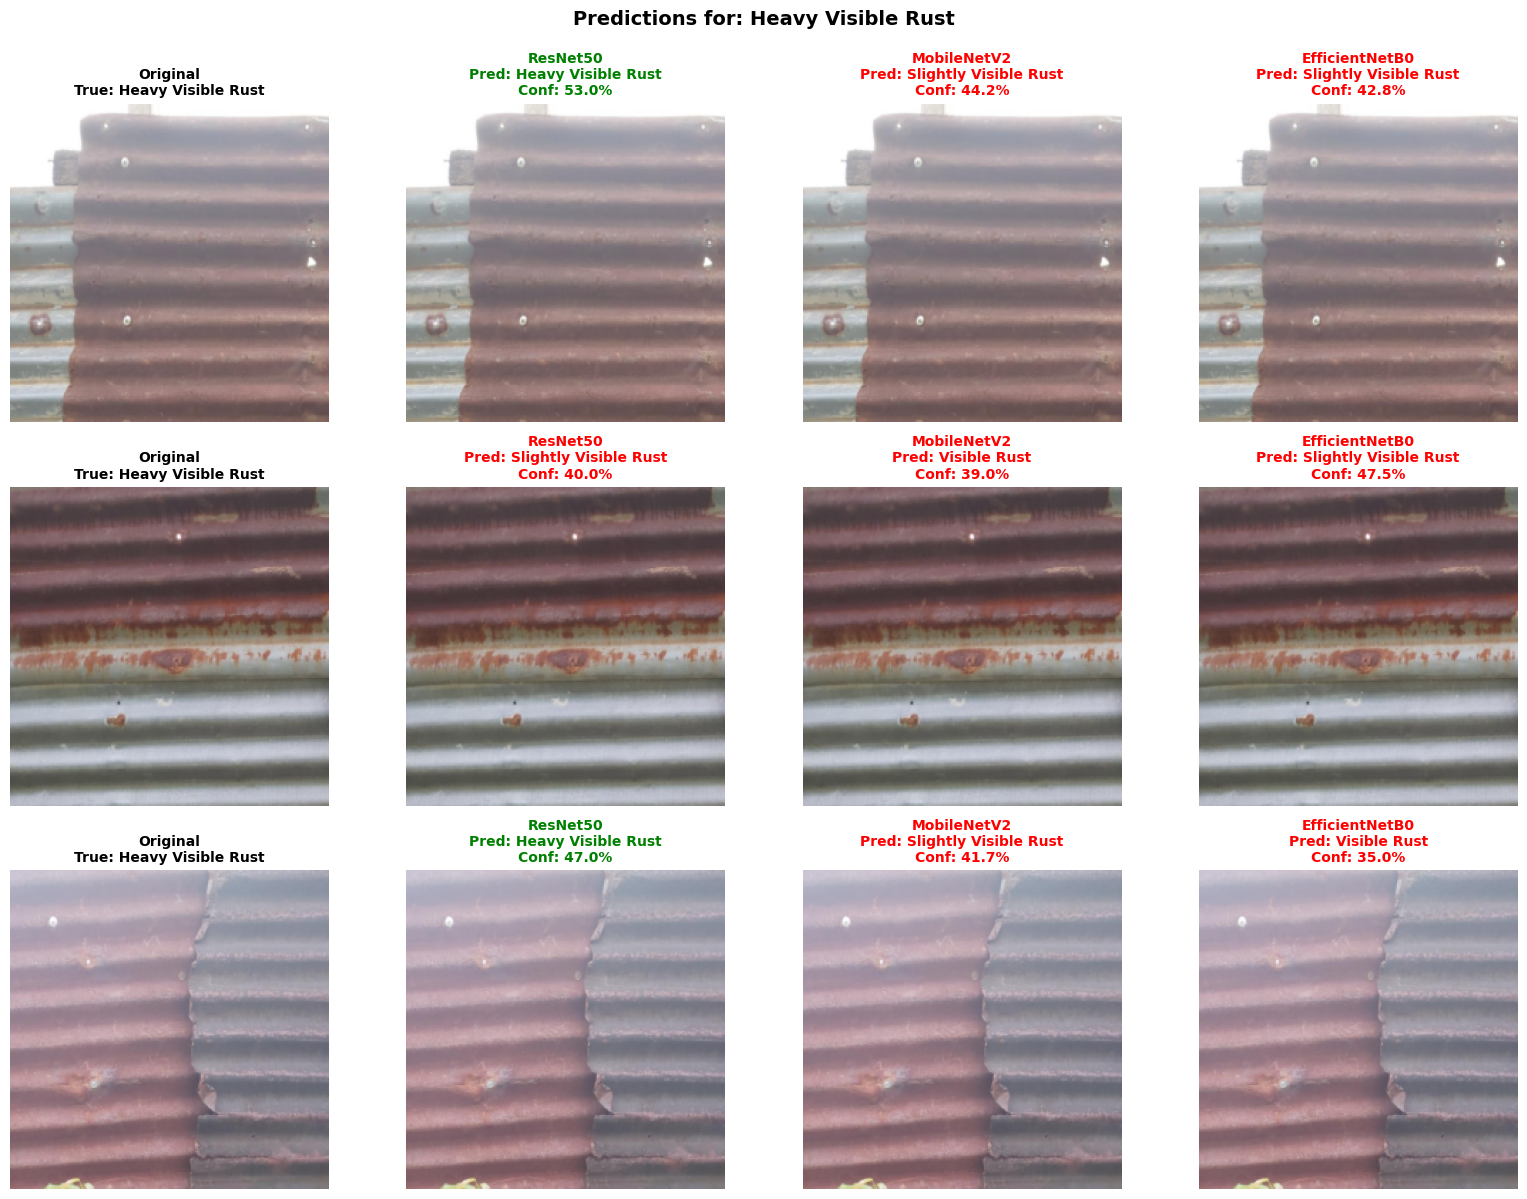


Class: No Rust


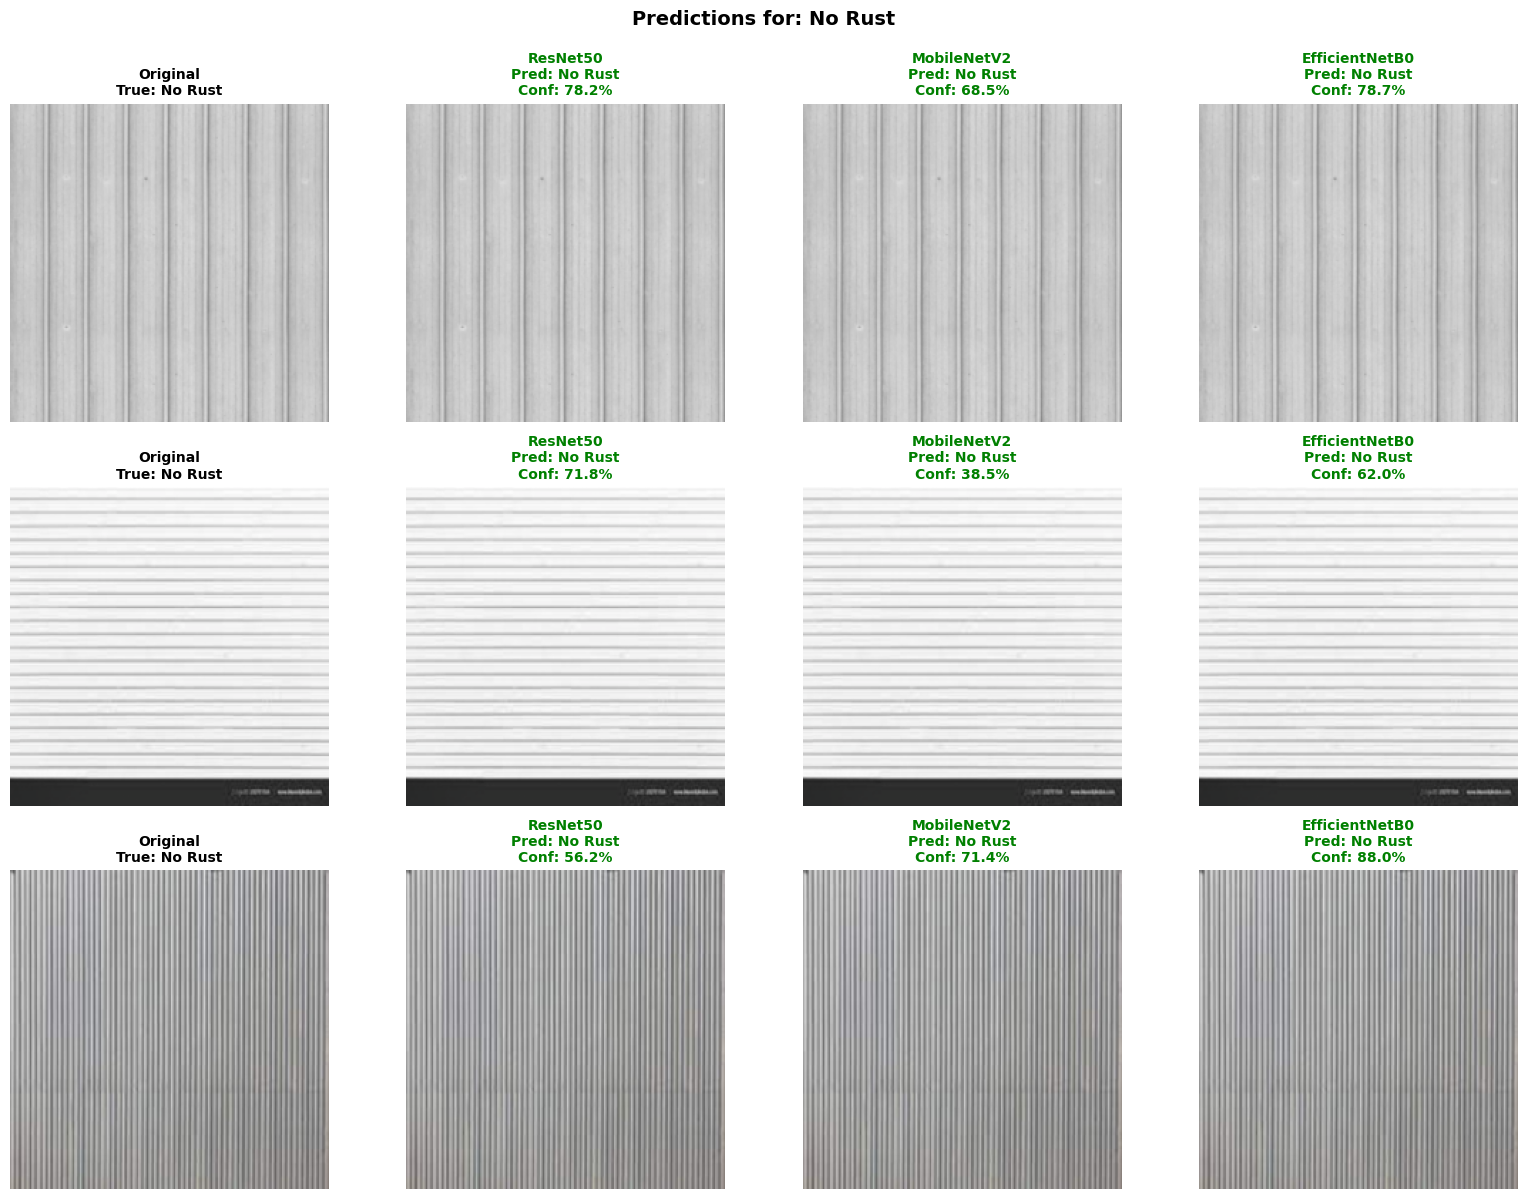


Class: Slightly Visible Rust


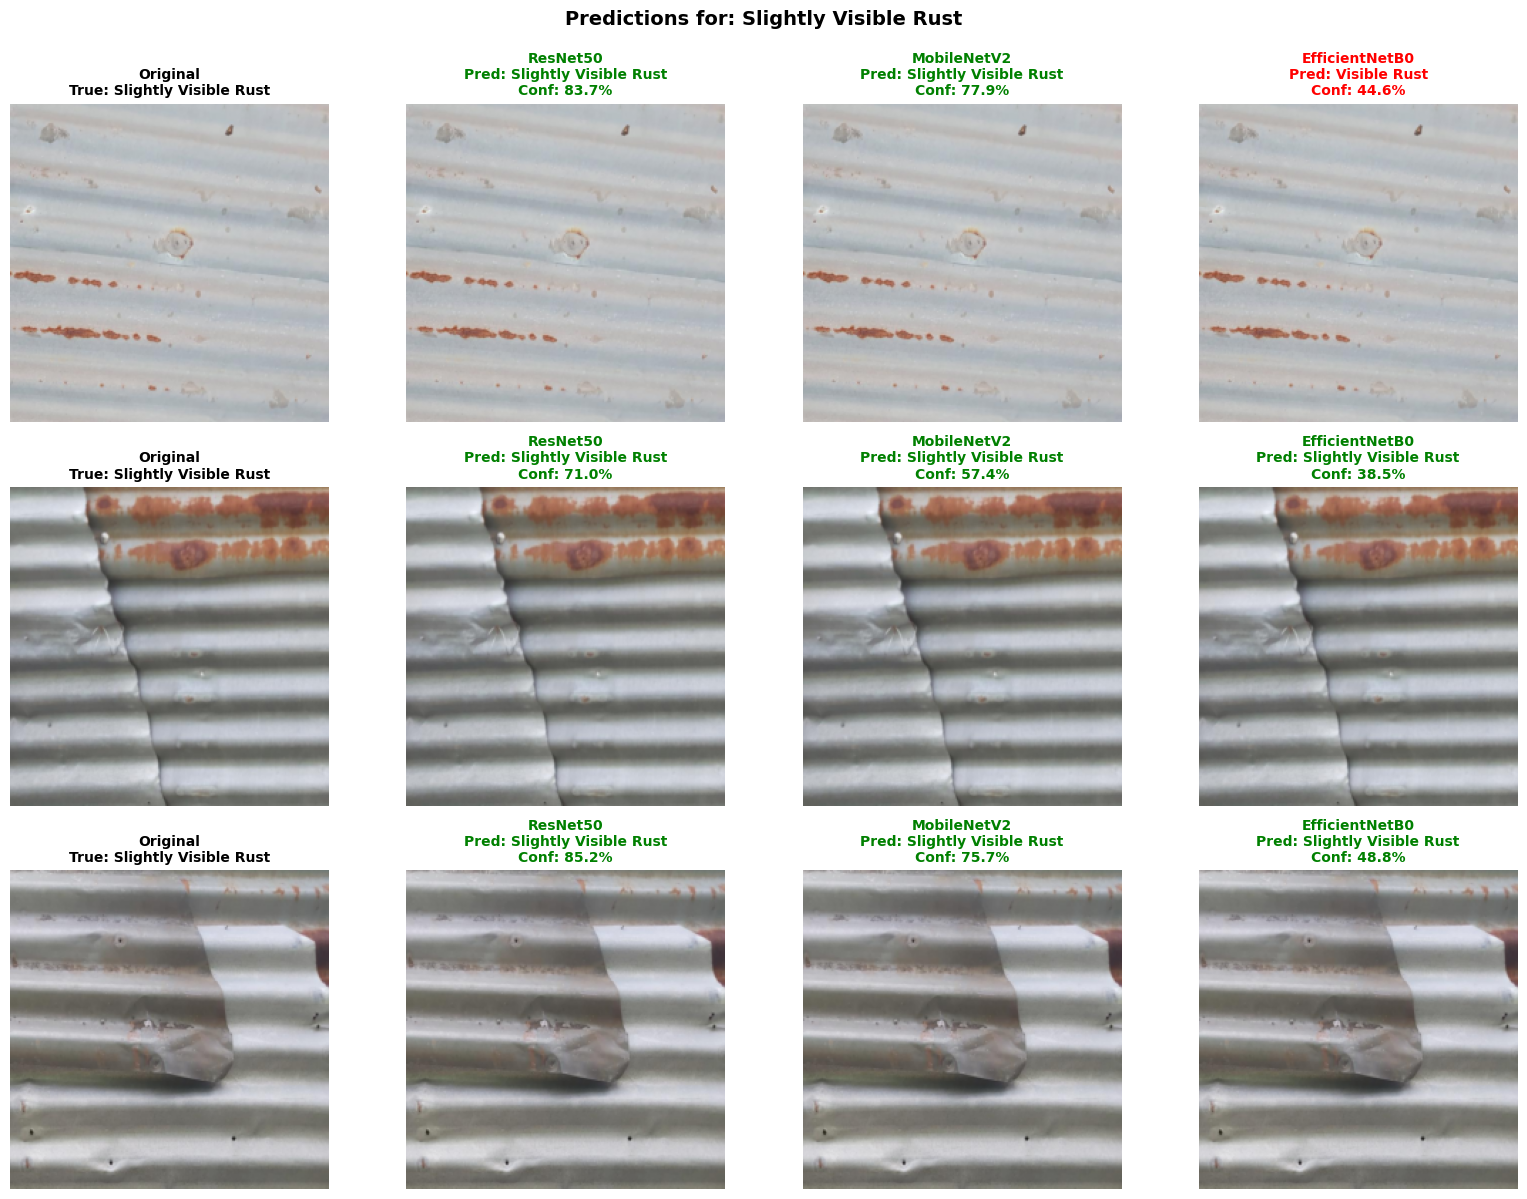


Class: Visible Rust


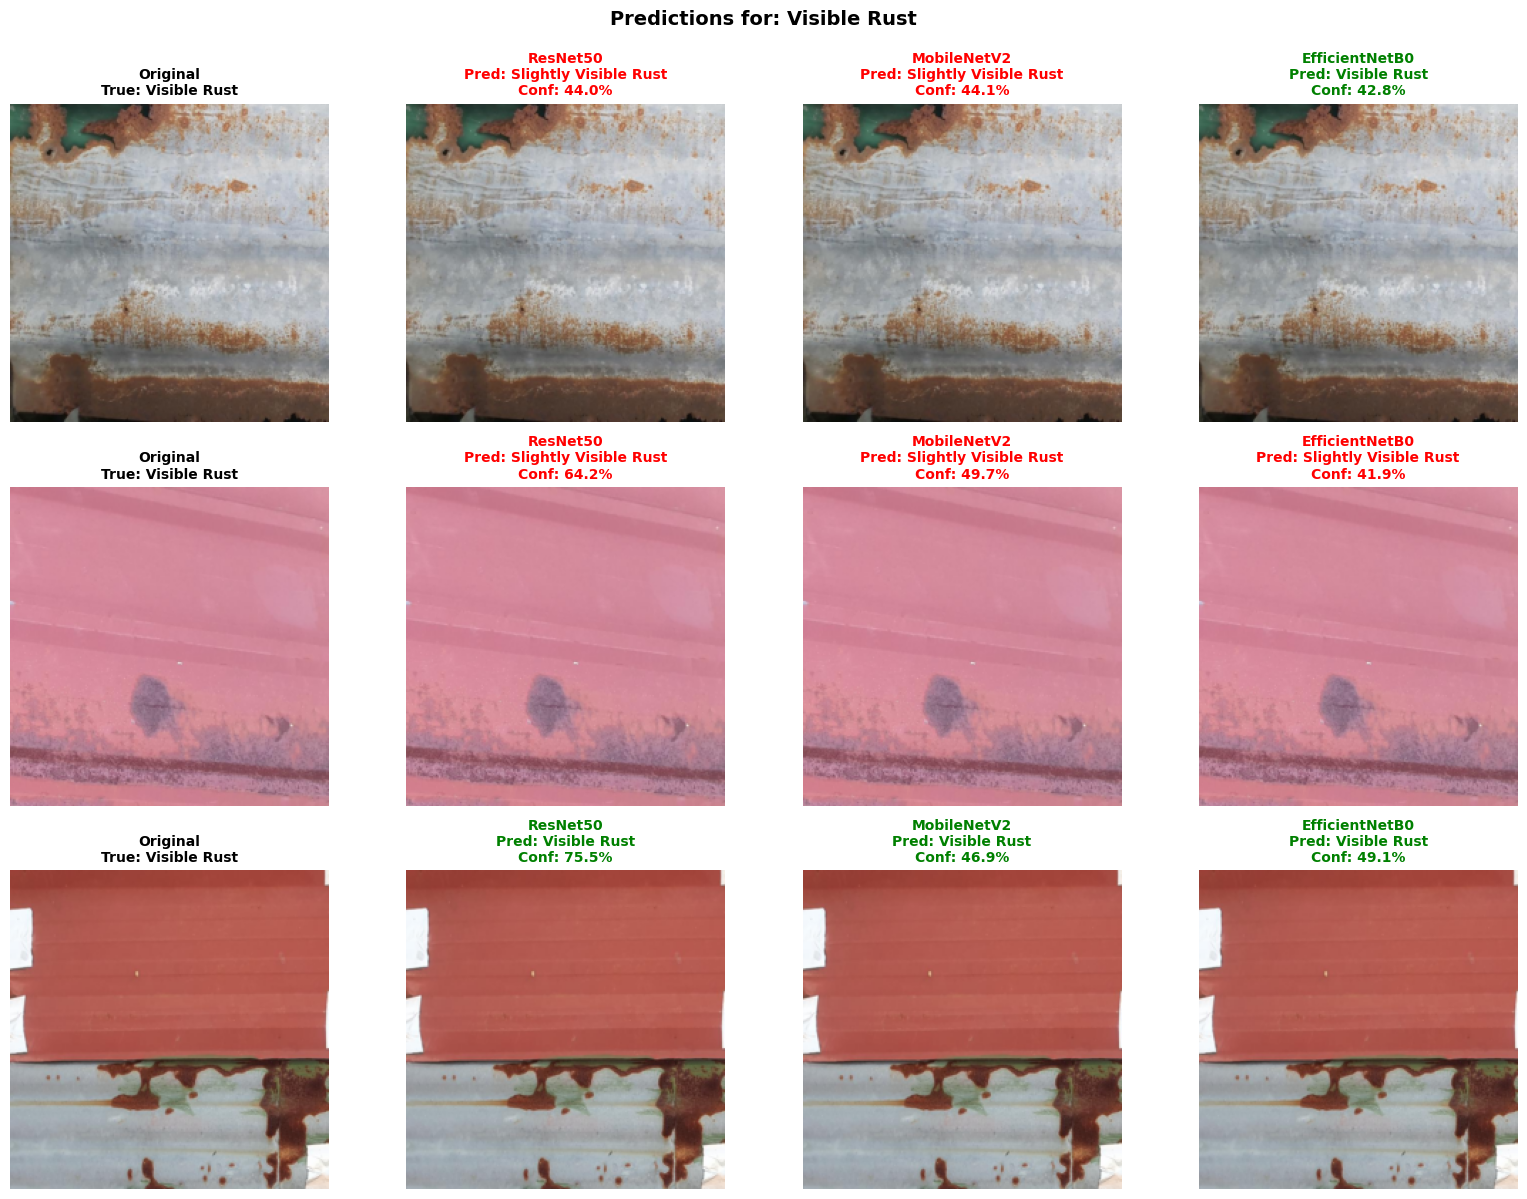

In [ ]:
# Visualize predictions for all models on sample images
for class_idx in range(NUM_CLASSES):
    if len(class_samples[class_idx]) == 0:
        continue
    
    print(f"\n{'='*80}")
    print(f"Class: {CLASS_NAMES[class_idx]}")
    print(f"{'='*80}")
    
    fig, axes = plt.subplots(samples_per_class, 5, figsize=(20, 4*samples_per_class))
    if samples_per_class == 1:
        axes = axes.reshape(1, -1)
    
    for row, (idx, img_tensor, true_label) in enumerate(class_samples[class_idx]):
        # Denormalize image for display
        img_display = denormalize(img_tensor).permute(1, 2, 0).numpy()
        img_display = np.clip(img_display, 0, 1)
        
        # Get predictions from all models
        resnet_pred, resnet_conf = predict_and_display(resnet_model, img_tensor, true_label, "ResNet50")
        mobilenet_pred, mobilenet_conf = predict_and_display(mobilenet_model, img_tensor, true_label, "MobileNetV2")
        efficientnet_pred, efficientnet_conf = predict_and_display(efficientnet_model, img_tensor, true_label, "EfficientNetB0")
        densenet_pred, densenet_conf = predict_and_display(densenet_model, img_tensor, true_label, "DenseNet121")
        
        # Original image
        axes[row, 0].imshow(img_display)
        axes[row, 0].set_title(f'Original\nTrue: {CLASS_NAMES[true_label]}', fontsize=10, fontweight='bold')
        axes[row, 0].axis('off')
        
        # ResNet50 prediction
        axes[row, 1].imshow(img_display)
        color = 'green' if resnet_pred == true_label else 'red'
        axes[row, 1].set_title(f'ResNet50\nPred: {CLASS_NAMES[resnet_pred]}\nConf: {resnet_conf*100:.1f}%', 
                               fontsize=10, color=color, fontweight='bold')
        axes[row, 1].axis('off')
        
        # MobileNetV2 prediction
        axes[row, 2].imshow(img_display)
        color = 'green' if mobilenet_pred == true_label else 'red'
        axes[row, 2].set_title(f'MobileNetV2\nPred: {CLASS_NAMES[mobilenet_pred]}\nConf: {mobilenet_conf*100:.1f}%', 
                               fontsize=10, color=color, fontweight='bold')
        axes[row, 2].axis('off')
        
        # EfficientNetB0 prediction
        axes[row, 3].imshow(img_display)
        color = 'green' if efficientnet_pred == true_label else 'red'
        axes[row, 3].set_title(f'EfficientNetB0\nPred: {CLASS_NAMES[efficientnet_pred]}\nConf: {efficientnet_conf*100:.1f}%', 
                               fontsize=10, color=color, fontweight='bold')
        axes[row, 3].axis('off')
        
        # DenseNet121 prediction
        axes[row, 4].imshow(img_display)
        color = 'green' if densenet_pred == true_label else 'red'
        axes[row, 4].set_title(f'DenseNet121\nPred: {CLASS_NAMES[densenet_pred]}\nConf: {densenet_conf*100:.1f}%', 
                               fontsize=10, color=color, fontweight='bold')
        axes[row, 4].axis('off')
    
    plt.suptitle(f'Predictions for: {CLASS_NAMES[class_idx]}', fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

In [ ]:
# Per-class accuracy for each model
from sklearn.metrics import classification_report

print("\n" + "="*80)
print("RESNET50 - Classification Report")
print("="*80)
print(classification_report(resnet_labels, resnet_preds, target_names=CLASS_NAMES, digits=4))

print("\n" + "="*80)
print("MOBILENETV2 - Classification Report")
print("="*80)
print(classification_report(mobilenet_labels, mobilenet_preds, target_names=CLASS_NAMES, digits=4))

print("\n" + "="*80)
print("EFFICIENTNETB0 - Classification Report")
print("="*80)
print(classification_report(efficientnet_labels, efficientnet_preds, target_names=CLASS_NAMES, digits=4))

print("\n" + "="*80)
print("DENSENET121 - Classification Report")
print("="*80)
print(classification_report(densenet_labels, densenet_preds, target_names=CLASS_NAMES, digits=4))


RESNET50 - Classification Report
                       precision    recall  f1-score   support

   Heavy Visible Rust     0.7500    0.6000    0.6667        10
              No Rust     1.0000    1.0000    1.0000        13
Slightly Visible Rust     0.7333    0.8462    0.7857        26
         Visible Rust     0.7500    0.6429    0.6923        14

             accuracy                         0.7937        63
            macro avg     0.8083    0.7723    0.7862        63
         weighted avg     0.7947    0.7937    0.7903        63


MOBILENETV2 - Classification Report
                       precision    recall  f1-score   support

   Heavy Visible Rust     0.5000    0.4000    0.4444        10
              No Rust     1.0000    1.0000    1.0000        13
Slightly Visible Rust     0.6897    0.7692    0.7273        26
         Visible Rust     0.5385    0.5000    0.5185        14

             accuracy                         0.6984        63
            macro avg     0.6820    0.6673

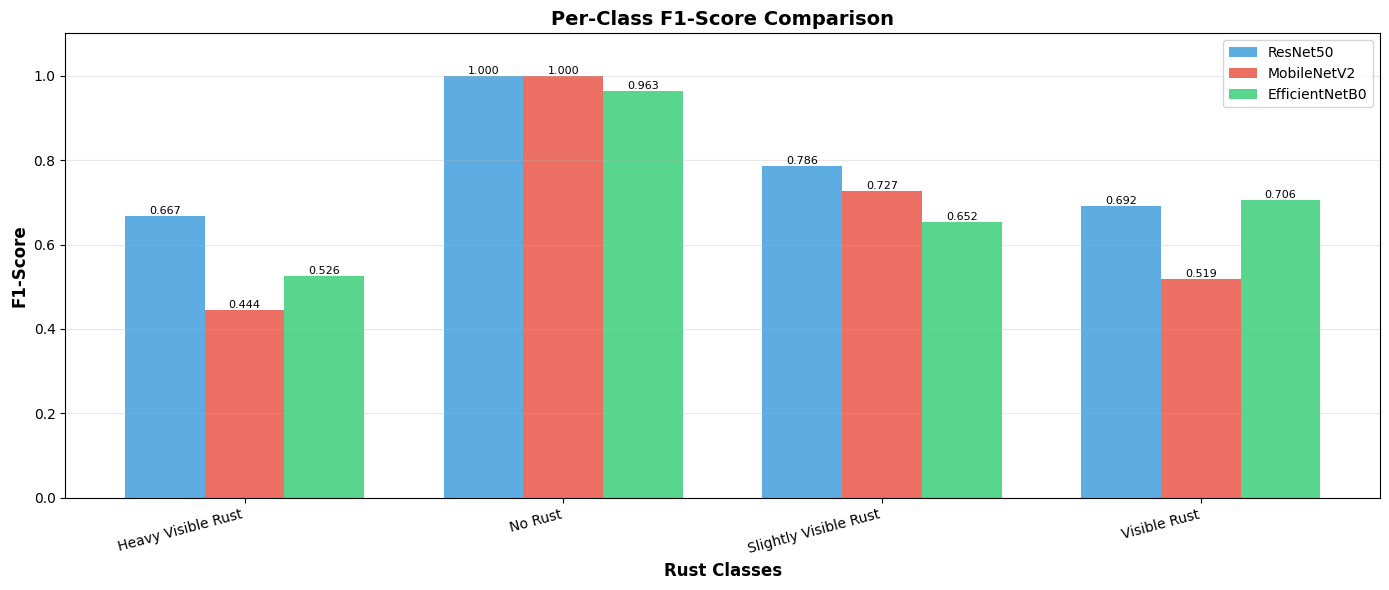

In [ ]:
# Per-class accuracy comparison visualization
from sklearn.metrics import precision_recall_fscore_support

resnet_metrics = precision_recall_fscore_support(resnet_labels, resnet_preds, average=None)
mobilenet_metrics = precision_recall_fscore_support(mobilenet_labels, mobilenet_preds, average=None)
efficientnet_metrics = precision_recall_fscore_support(efficientnet_labels, efficientnet_preds, average=None)
densenet_metrics = precision_recall_fscore_support(densenet_labels, densenet_preds, average=None)

# Plot F1-scores per class
x = np.arange(len(CLASS_NAMES))
width = 0.2

fig, ax = plt.subplots(figsize=(16, 6))
bars1 = ax.bar(x - 1.5*width, resnet_metrics[2], width, label='ResNet50', color='#3498db', alpha=0.8)
bars2 = ax.bar(x - 0.5*width, mobilenet_metrics[2], width, label='MobileNetV2', color='#e74c3c', alpha=0.8)
bars3 = ax.bar(x + 0.5*width, efficientnet_metrics[2], width, label='EfficientNetB0', color='#2ecc71', alpha=0.8)
bars4 = ax.bar(x + 1.5*width, densenet_metrics[2], width, label='DenseNet121', color='#9b59b6', alpha=0.8)

ax.set_xlabel('Rust Classes', fontsize=12, fontweight='bold')
ax.set_ylabel('F1-Score', fontsize=12, fontweight='bold')
ax.set_title('Per-Class F1-Score Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(CLASS_NAMES, rotation=15, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.1)

# Add value labels on bars
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=7)

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)
add_value_labels(bars4)

plt.tight_layout()
plt.show()

In [ ]:
# Final summary
print("\n" + "="*80)
print("FINAL TEST RESULTS SUMMARY")
print("="*80)
print(f"Total test images: {len(test_dataset)}")
print(f"\nModel Accuracies:")
print(f"  1. ResNet50:       {resnet_acc:.2f}%")
print(f"  2. MobileNetV2:    {mobilenet_acc:.2f}%")
print(f"  3. EfficientNetB0: {efficientnet_acc:.2f}%")
print(f"  4. DenseNet121:    {densenet_acc:.2f}%")
print(f"\nBest performing model: {models_list[np.argmax(accuracies)]} ({max(accuracies):.2f}%)")
print("="*80)


FINAL TEST RESULTS SUMMARY
Total test images: 63

Model Accuracies:
  1. ResNet50:       79.37%
  2. MobileNetV2:    69.84%
  3. EfficientNetB0: 71.43%

Best performing model: ResNet50 (79.37%)
